In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from xskillscore import crps_ensemble

In [3]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [4]:
def fair_crps_ensemble(observations, forecasts, axis=0):

    # Convert inputs to numpy arrays if they're not already
    forecasts = np.asarray(forecasts)
    observations = np.asarray(observations)
    
    if axis != 1:
        forecasts = np.moveaxis(forecasts, axis, 1)
    
    # Get number of ensemble members
    m = forecasts.shape[1]
    
    # Calculate dxy: sum of absolute differences between forecasts and observations
    # Add a dimension to observations to allow broadcasting
    observations_expanded = np.expand_dims(observations, axis=1)
    dxy = np.sum(np.abs(forecasts - observations_expanded), axis=1)
    
    # Calculate dxx: sum of absolute differences between all pairs of ensemble members
    # Add dimensions to enable broadcasting for pairwise differences
    forecast_i = np.expand_dims(forecasts, axis=2)  # [batch, ens, 1, ...]
    forecast_j = np.expand_dims(forecasts, axis=1)  # [batch, 1, ens, ...]
    dxx = np.sum(np.abs(forecast_i - forecast_j), axis=(1, 2))
    
    # Calculate CRPS using the kernel approximation formula
    crps = dxy / m - dxx / (m * (m - 1) * 2)
    
    return crps

### Data preparation

In [5]:
#ssrd6
test_rfcs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [6]:
test_rfcs=test_rfcs
obs=obs

In [7]:
print(list(test_rfcs.data_vars))

['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']


In [8]:
target='ssrd6_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars([  'sd',  'q'])
#test_rfcs=test_rfcs.drop_vars(['sd', 'mx2t6', 'mn2t6',  'q','ssr6','str6']) --
#test_rfcs=test_rfcs.drop_vars(['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'tp6', 'ssr6', 'str6', 'strd6'])
#test_rfcs=test_rfcs.drop_vars(['u10', 'v10', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'ssr6', 'str6']) #8
#[ 'sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6']
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [9]:
print(list(test_rfcs.data_vars))

['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']


In [ ]:
print(obs.shape)

In [10]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [ ]:
print(obs)

In [11]:
fcs_10=xr.merge([test_rfcs,final_oro])

In [12]:
print(list(fcs_10.data_vars))

['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6', 'oro']


In [13]:
dummy=xr.merge([test_rfcs,final_oro])

In [14]:
#normalizing met oro.nc
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800),"ssr6":(0,3200000),"ssrd6":(-5200.0,18541902.0),"strd6":(2103856,9537712),"tp6":(-4,1),"ssr6":(-4220.0,15344816.0),"str6":(-4630656.0,1093968.0)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [15]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 22), n_heads=8,mlp_mult=4,projection_channels=64)

### Actual testing

In [16]:
#this is where the last run is stored 
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/ssrd6/epochs50predictors22CRPSKERNELSTEPlambda0.02k3.3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1552417


In [17]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
#print(fcs_norm_whole)

Frozen({'variable': 22, 'time': 209, 'number': 11, 'step': 20, 'latitude': 32, 'longitude': 33})


In [18]:
print(fcs_norm_whole.shape)

(22, 209, 11, 20, 32, 33)


In [19]:
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')

In [20]:
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

torch.Size([209, 11, 20, 32, 33, 22])


In [21]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')

In [22]:
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')

In [23]:
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 22])


In [24]:
import torch
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        #print(fcs_whole_tensor[i:end].shape)
        #print(postpro_10_whole[i:end].shape)
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [25]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [27]:
# Extract ensemble forecasts
ensemble_one = postpro_10_whole[...,0]

# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 19], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_one = scale_and_clamp(ensemble_one)

In [28]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
print("MBM_one shape:", MBM_one.shape)

MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)

# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

MBM_one shape: (209, 11, 20, 32, 33)


In [29]:
#ALL ENSEMBLES
Tformer_one=full_ensemble_one

MBM_one = MBM_one
Raw = raw_fcs['ssrd6']
obs=obs.squeeze()

In [30]:
import xskillscore as xs

output_dir = "/home/jupyter-ayoub/results/CRPS"
os.makedirs(output_dir, exist_ok=True)

# Load observations (assuming you have them)
observations = obs
#print(Tformer_one)
# Dictionary of ensemble forecasts
ensembles = {
    "Tformer_one": Tformer_one,
    "MBM_one": MBM_one,
    "Raw": Raw
}

# Process each ensemble
for name, ensemble in ensembles.items():
    print(f"Processing {name}...")
    
    obs_broadcast = observations
    
    # Initialize arrays to store CRPS values
    # Assuming we compute CRPS for each leadtime
    n_leadtimes = ensemble.shape[2]
    #print(n_leadtimes)
    #gaussian_crps = np.zeros(n_leadtimes)
    fair_crps = np.zeros(n_leadtimes)
    
    # Compute CRPS for each leadtime
    for lt in range(n_leadtimes):
        
        # Extract data for this leadtime
        ensemble_lt = ensemble[:, :, lt, :, :]  # (member, time, lat, lon)
        obs_lt = obs_broadcast[:, lt, :, :]  # (time, lat, lon)
        
        # Convert to xarray for xs.crps_gaussian
        ensemble_xr = xr.DataArray(
            ensemble_lt, 
            dims=["member", "time", "latitude", "longitude"]
        )
        
        obs_xr = xr.DataArray(
            obs_lt,
            dims=["time", "latitude", "longitude"]
        )
        
        # Compute Gaussian CRPS
        # Mean and standard deviation along member dimension
        #mean = ensemble_xr.mean(dim="member")
        #print(mean)
        #std = ensemble_xr.std(dim="member")
        #print(std)
        #g_crps = xs.crps_gaussian(obs_xr, mean, std)
        #gaussian_crps[lt] = g_crps.mean().values
        
        # Compute fair ensemble CRPS
        f_crps = fair_crps_ensemble(obs_lt, ensemble_lt, axis=0)
        #print(f_crps.shape)
        fair_crps[lt] = np.mean(f_crps)
    
    # Save results
    #np.save(f"{output_dir}/{name}_gaussian_crps.npy", gaussian_crps)
    np.save(f"{output_dir}/{name}_fair_crps.npy", fair_crps)
    

print("All CRPS computations complete!")

Processing Tformer_one...
Processing MBM_one...
Processing Raw...
All CRPS computations complete!


TESTING

In [ ]:
np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_fair_crps.npy")

In [31]:
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_fair_crps.npy")
#CRPS_TF_1_G = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_gaussian_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_fair_crps.npy")
#CRPS_MBM_1_G = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_gaussian_crps.npy")
CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/Raw_fair_crps.npy")
#CRPS_OG_G=np.load("/home/jupyter-ayoub/results/CRPS/Raw_gaussian_crps.npy")
meanOG=np.mean(CRPS_OG)
#meanOG_g=np.mean(CRPS_OG_G)
meanmbm_1=np.mean(CRPS_MBM_1)
#meanmbm_1_g=np.mean(CRPS_MBM_1_G)
meantf_1=np.mean(CRPS_TF_1)
#meantf_1_g=np.mean(CRPS_TF_1_G)
#print(meanOG,meanOG_g,meanmbm_1,meanmbm_1_g,meantf_1,meantf_1_g)
print(meanOG,meanmbm_1,meantf_1,)

342434.3021368424 377086.03610573284 706702.4569835167


In [ ]:
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(20, 15))
plt.plot(Leadtimes, CRPS_OG, color='red', marker='o', label='Original')
plt.plot(Leadtimes, CRPS_TF_1, color='cyan',linestyle=':', marker='d' ,alpha=0.5,label='Postprocessed,Transformer 1 pred')
plt.plot(Leadtimes, CRPS_MBM_1, color='brown',linestyle=':', marker='*',alpha=0.5, label='Postprocessed, Classical MBM 1 pred')

print(meanOG)
print(meantf_1)
print(meanmbm_1)
plt.axhline(y=meanOG, color='red',linestyle=':')
plt.axhline(y=meantf_1, color='cyan',linestyle=':')
plt.axhline(y=meanmbm_1, color='brown',linestyle=':')

# Set title and labels
plt.title('Ensemble CRPS per lead time (wind speed 100m)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('CRPS [metres per second.]', fontsize=18)

# Set y-axis limits and x-axis ticks
plt.xlim(0,123)
plt.ylim(5000,1000000)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.show()

In [ ]:
#Example of an ensemble
np.random.seed(156)  # For reproducibility #156
random_time = np.random.randint(0, Tformer_one.sizes["time"])
random_lat = np.random.randint(0, Tformer_one.sizes["latitude"])
random_lon = np.random.randint(0, Tformer_one.sizes["longitude"])

# Extract data for all 11 ensemble members at the chosen location
TF = Tformer_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
MBM = MBM_one[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
OBS = obs[random_time, :, random_lat, random_lon] 
RAW = Raw[:, random_time, :, random_lat, random_lon]  # Shape: (11, step)
# Plot all ensemble members as a function of step
plt.figure(figsize=(10, 6))
#plt.plot(MBM_one.step, np.mean(RAW,axis=0),color='red',alpha=0.8,label="Raw Forecasts")
plt.plot(MBM_one.step, np.mean(MBM,axis=0),color='black',alpha=0.8,label="Classical MBM")
plt.plot(Tformer_one.step, np.mean(TF,axis=0),color='blue',alpha=0.8,label="Transformer")
plt.plot(MBM_one.step, OBS,color='green',alpha=0.8,label="Observations")
for member in range(TF.sizes["member"]):
    plt.plot(Tformer_one.step, TF[member, :],color='blue',alpha=0.2)
    plt.plot(MBM_one.step, MBM[member, :],color='black',alpha=0.2)
    #plt.plot(raw_fcs.step, RAW[member,:],color='red',alpha=0.2)

# Formatting the plot
plt.xlabel("Timestep, ")
plt.ylabel("windspeed 100m")
plt.title("windspeed, randomly selected day",fontsize="20")
plt.legend(loc="upper right", fontsize=12, ncol=2)
plt.grid(True)
plt.show()

TF shape: (20,)
MBM shape: (20,)
OG shape: (20,)


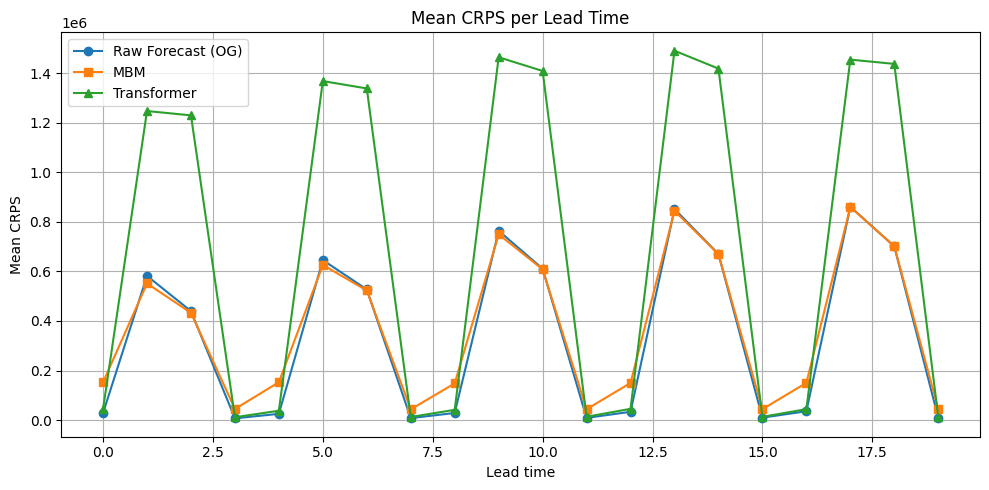

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Load CRPS arrays
CRPS_TF_1 = np.load("/home/jupyter-ayoub/results/CRPS/Tformer_one_fair_crps.npy")
CRPS_MBM_1 = np.load("/home/jupyter-ayoub/results/CRPS/MBM_one_fair_crps.npy")
CRPS_OG = np.load("/home/jupyter-ayoub/results/CRPS/Raw_fair_crps.npy")

# Check shape
print("TF shape:", CRPS_TF_1.shape)
print("MBM shape:", CRPS_MBM_1.shape)
print("OG shape:", CRPS_OG.shape)

# Zorg dat we shape hebben van (samples, leadtimes) → dan nemen we mean over samples
def get_leadtime_mean(crps_array):
    if crps_array.ndim == 2:
        # (samples, leadtimes) of (leadtimes, samples)
        if crps_array.shape[0] < crps_array.shape[1]:
            return crps_array.mean(axis=0)  # (samples, leadtimes)
        else:
            return crps_array.mean(axis=1)  # (leadtimes, samples)
    elif crps_array.ndim == 3:
        return crps_array.mean(axis=(1,2))  # (leadtimes, lat, lon)
    elif crps_array.ndim == 1:
        return crps_array  # enkel 1 lead time, al geaggregeerd
    else:
        raise ValueError("Onverwachte CRPS shape.")

mean_crps_tf = get_leadtime_mean(CRPS_TF_1)
mean_crps_mbm = get_leadtime_mean(CRPS_MBM_1)
mean_crps_og = get_leadtime_mean(CRPS_OG)

# Plot alle leadtimes
lead_times = np.arange(len(mean_crps_tf))
plt.figure(figsize=(10, 5))
plt.plot(lead_times, mean_crps_og, label='Raw Forecast (OG)', marker='o')
plt.plot(lead_times, mean_crps_mbm, label='MBM', marker='s')
plt.plot(lead_times, mean_crps_tf, label='Transformer', marker='^')
plt.xlabel("Lead time")
plt.ylabel("Mean CRPS")
plt.title("Mean CRPS per Lead Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



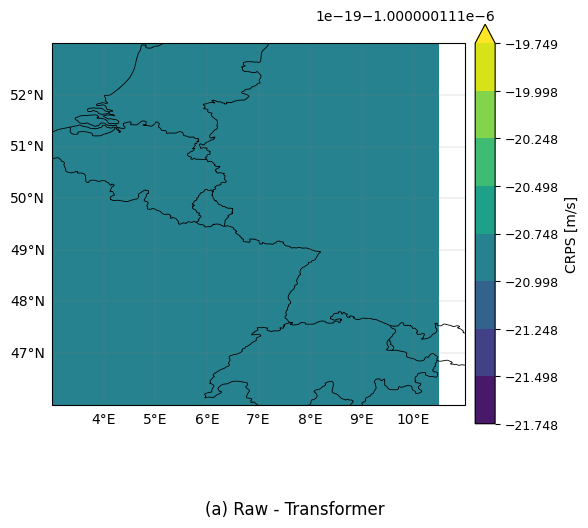

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Data voorbereiden
np.random.seed(156)
random_step = np.random.randint(0, Tformer_one.sizes["step"])
TF = Tformer_one.isel(step=random_step).mean("member").isel(time=0)
RAW = Raw.isel(step=random_step).mean("member").isel(time=0)
diff = RAW - TF

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(diff.longitude, diff.latitude)

# Plotfiguur
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([3, 11, 46, 53], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
#levels = np.linspace(0, 0.27, 10)
cf = ax.contourf(lon2d, lat2d, diff.values,
                 
                 transform=ccrs.PlateCarree(), extend='max')

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.85, aspect=20)
cbar.set_label(r'CRPS [m/s]', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.figtext(0.5, -0.08, r"(a) Raw - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()


In [ ]:
ranks_raw = Raw     # shape: (n_points,)
ranks_mbm = MBM_one
ranks_tf = Tformer_one

print(ranks_raw.shape)
print(ranks_mbm.shape)
print(ranks_tf.shape)
bins = np.arange(13) - 0.5  # voor 12-rank histogram

plt.figure(figsize=(6, 4))
plt.hist(ranks_raw, bins=bins, alpha=0.6, label="Raw", color="red", density=True)
plt.hist(ranks_mbm, bins=bins, alpha=0.6, label="Postprocessed, classical MBM", color="black", density=True)
plt.hist(ranks_tf, bins=bins, alpha=0.6, label="Postprocessed, Transformer", color="blue", density=True)
plt.xlabel("Rank of observed value")
plt.ylabel("Relative frequency")
plt.xticks(np.arange(12))
plt.title("(f) Rank histogram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Gemiddelde nemen over lat/lon → shape wordt (11, 209, 20)
ranks_raw = Raw.mean(dim=["latitude", "longitude"]).values   # or use .isel if needed
ranks_mbm = MBM_one.mean(dim=["latitude", "longitude"]).values
ranks_tf = Tformer_one.mean(dim=["latitude", "longitude"]).values

# Kies 1 ensemble lid (of het gemiddelde): shape (209, 20)
ranks_raw = ranks_raw[0]   # bijv. lid 0
ranks_mbm = ranks_mbm[0]
ranks_tf = ranks_tf[0]

# Flatten naar 1D (zoals vereist door plt.hist)
ranks_raw = ranks_raw.flatten()
ranks_mbm = ranks_mbm.flatten()
ranks_tf = ranks_tf.flatten()

# Plot histogram
bins = np.arange(13) - 0.5  # 12 ranks → bins van -0.5 tot 11.5

plt.figure(figsize=(6, 4))
plt.hist(ranks_raw, bins=bins, alpha=0.6, label="Raw", color="red", density=True)
plt.hist(ranks_mbm, bins=bins, alpha=0.6, label="Postprocessed, classical MBM", color="black", density=True)
plt.hist(ranks_tf, bins=bins, alpha=0.6, label="Postprocessed, Transformer", color="blue", density=True)

plt.xlabel("Rank of observed value")
plt.ylabel("Relative frequency")
plt.xticks(np.arange(12))
plt.title("(f) Rank histogram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
